In [49]:
import numpy as np
import CS_functions as cs
from time import time
from matplotlib import pyplot as plt
from scipy import fft as spfft
from scipy.constants import c as C

plt.rcParams.update({'font.size':24, 'xtick.minor.visible': False, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})

def format_runtime(seconds):
    if isinstance(seconds, str):
        return seconds
    
    elif seconds < 1e-3:
        return f"Runtime = {seconds*1e6:.0f} µs"
    elif seconds < 1:
        return f"Runtime = {seconds*1e3:.0f} ms"
    elif seconds < 60:
        return f"Runtime = {seconds:.0f} s"
    elif seconds < 3600:
        return f"Runtime = {seconds/60:.0f} min"
    elif seconds < 86400:
        return f"Runtime = {seconds/3600:.0f} hours"
    else:
        return f"Runtime = {seconds/86400:.0f} days"

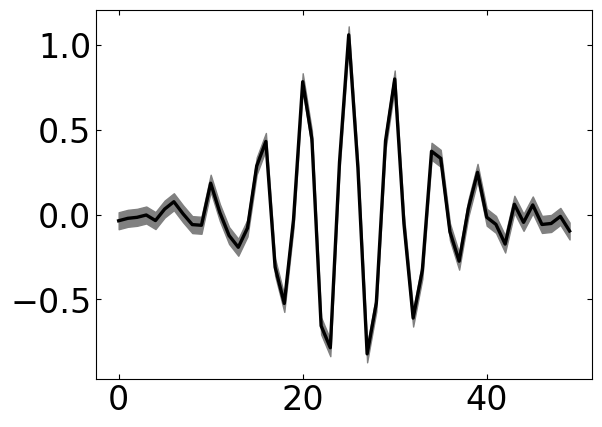

In [50]:
file_number = 31 # Use a noiseless version of the interferogram for good convergence
file_name = "1dmockanderrors{:d}".format(file_number)

file_type = ".csv"
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

target, target_err = cs.open_dataset(file_name, file_type)
target_len = len(target)

fig, axs = plt.subplots()

axs.plot(target, color= "k")
axs.fill_between(range(target_len), target-target_err, target+target_err, color= "gray")

plt.show()

In [51]:
optimised_samples = {}
scores = {}
runtimes = {}
samples_len = 4

optimised_samples["Uniform sampling"] = cs.subsample_1d(target_len, samples_len, "regular")
scores["Uniform sampling"] = cs.evaluate_score(optimised_samples["Uniform sampling"], target, target_err)
runtimes["Uniform sampling"] = ""

optimised_samples["Brute force"] = np.array([21,25,27,44])
scores["Brute force"] = cs.evaluate_score(optimised_samples["Brute force"], target, target_err)
runtimes["Brute force"] = 200

t0 = time()
optimised_samples["Douglas-Peucker"], scores["Douglas-Peucker"] = cs.douglas_peucker(samples_len, target, target_err, regularization_coeffient)
runtimes["Douglas-Peucker"] = time() - t0
runtimes["Douglas-Peucker"] = runtimes["Douglas-Peucker"] or 1e-6 # DP is very fast. Faster than what can be reliably measured.

t0 = time()
optimised_samples["Greedy"], scores["Greedy"] = cs.greedy(samples_len, target, target_err, regularization_coeffient, subsampling_method="regular")
runtimes["Greedy"] = time() - t0

t0 = time()
optimised_samples["Metropolis"], scores["Metropolis"] = cs.MCMC_metropolis(samples_len, target, target_err, regularization_coeffient, subsampling_method="random", stepsize= 3, iterations= 5000)
runtimes["Metropolis"] = time() - t0

t0 = time()
optimised_samples["Simulated annealing"], scores["Simulated annealing"] = cs.simulated_annealing(samples_len, target, target_err, regularization_coeffient, subsampling_method="random", max_temp= 51, cooling= 0.995, iterations= 5000)
print(optimised_samples["Simulated annealing"])
runtimes["Simulated annealing"] = time() - t0


WARNING! Noiseless data not provided, assuming interferogram has no noise.
WARNING! Noiseless data not provided, assuming interferogram has no noise.
[19 23 25 29]


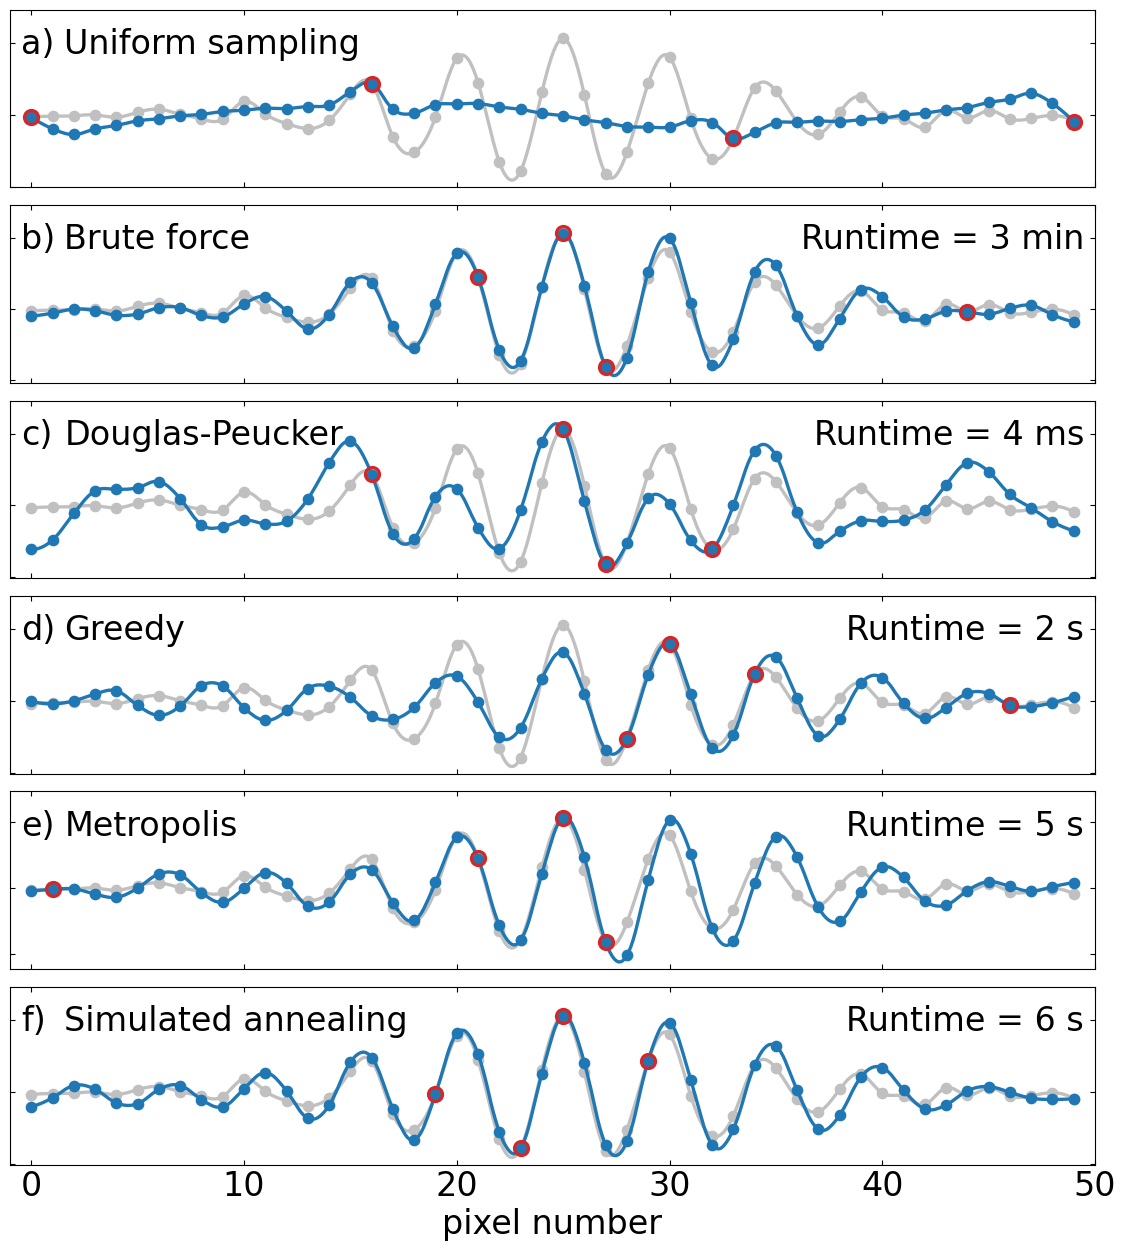

In [52]:
### INTERFEROGRAMS

number_of_methods = len(optimised_samples)

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.1}, facecolor='none')

for ax, method, sensors, runtime, score, label in zip(axs, optimised_samples.keys(), optimised_samples.values(), runtimes.values(), scores.values(), ["a)", "b)", "c)", "d)", "e)", "f)"]):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(target, color= "silver", marker= "o", linestyle= "none", markersize= 6)
    ax.plot(cs.interpolate(range(target_len), "cubic"), cs.interpolate(target, "cubic"), color= "silver")
    ax.plot(result, color= "tab:blue", marker= "o", linestyle= "none", markersize= 6)
    ax.plot(cs.interpolate(range(target_len), "cubic"), cs.interpolate(result), color= "tab:blue")
    ax.plot(sensors, samples[sensors], linestyle= "None", marker= "o", markeredgecolor= "tab:red", markerfacecolor= "None")
    ax.set(facecolor='white', ylim= (None, target.max() +0.4), yticklabels= [], xlim= (-1, target_len))
    #ax.annotate(method, (0.01,1.3), xycoords= 'axes fraction', ha= "left", va= "top"); ax.annotate(format_runtime(runtime), (0.55,1.3), xycoords= 'axes fraction', ha= "left", va= "top"); ax.annotate( r"$\chi ^2$ = {0:.1f}".format(score), (0.85,1.33), xycoords= 'axes fraction', ha= "left", va= "top")
    #ax.annotate(method, (0.01,1.3), xycoords= 'axes fraction', ha= "left", va= "top"); ax.annotate(format_runtime(runtime), (0.99,1.3), xycoords= 'axes fraction', ha= "right", va= "top")
    ax.annotate(method, (0.05,0.9), xycoords= 'axes fraction', ha= "left", va= "top"); ax.annotate(format_runtime(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
    ax.annotate(label, (0.01,0.9), xycoords= 'axes fraction', ha= "left", va= "top")
axs[-1].set(xlabel= "pixel number")

fig.savefig("./graphs/optimisation_comparason5a", bbox_inches= "tight")
plt.show()

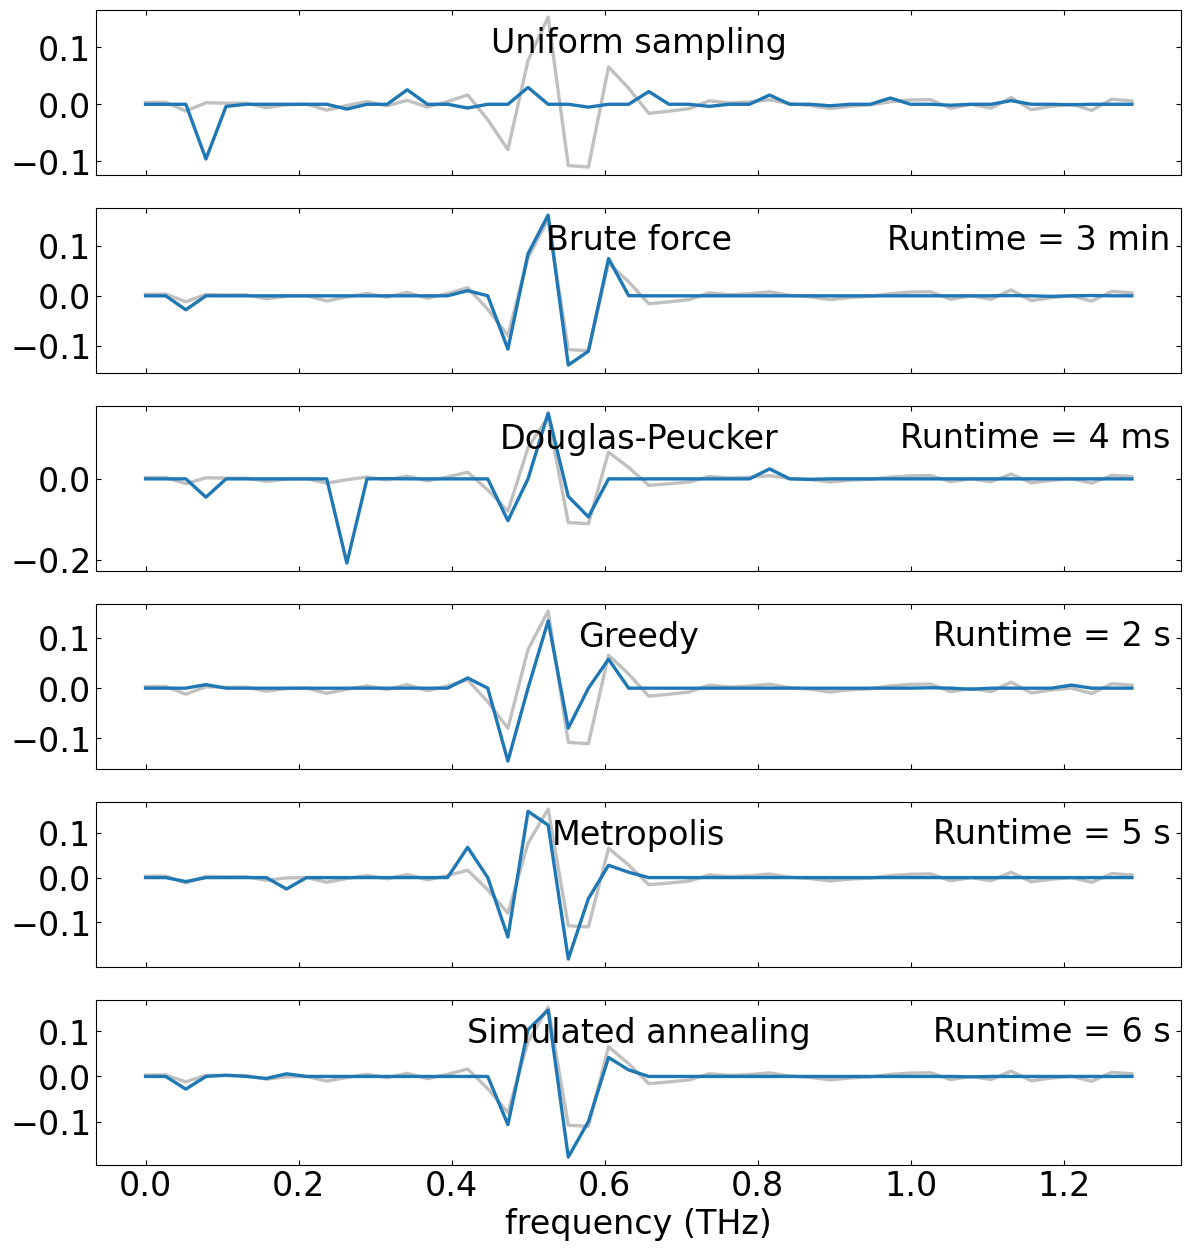

In [53]:
### DCT BASIS

pixel_pitch = 1 #mm
theta = 200 # arcminutes

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.2}, facecolor='none')

nyquist = C / (4 *pixel_pitch*1e-3 *np.sin(np.deg2rad(theta/60)))
nyquist *= 1e-12
freqs = np.linspace(0, nyquist, target_len) # THIS IS APPROXIMATE WHEN TOTAL_POINTS IS ODD.

for ax, method, sensors, runtime, score in zip(axs, optimised_samples.keys(), optimised_samples.values(), runtimes.values(), scores.values()):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "DCT")
    ax.plot(freqs, spfft.dct(target, type= 1, norm= "forward"), color= "silver")
    ax.plot(freqs, result)
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    ax.annotate(format_runtime(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

fig.savefig("./graphs/optimisation_comparason5b")
plt.show()

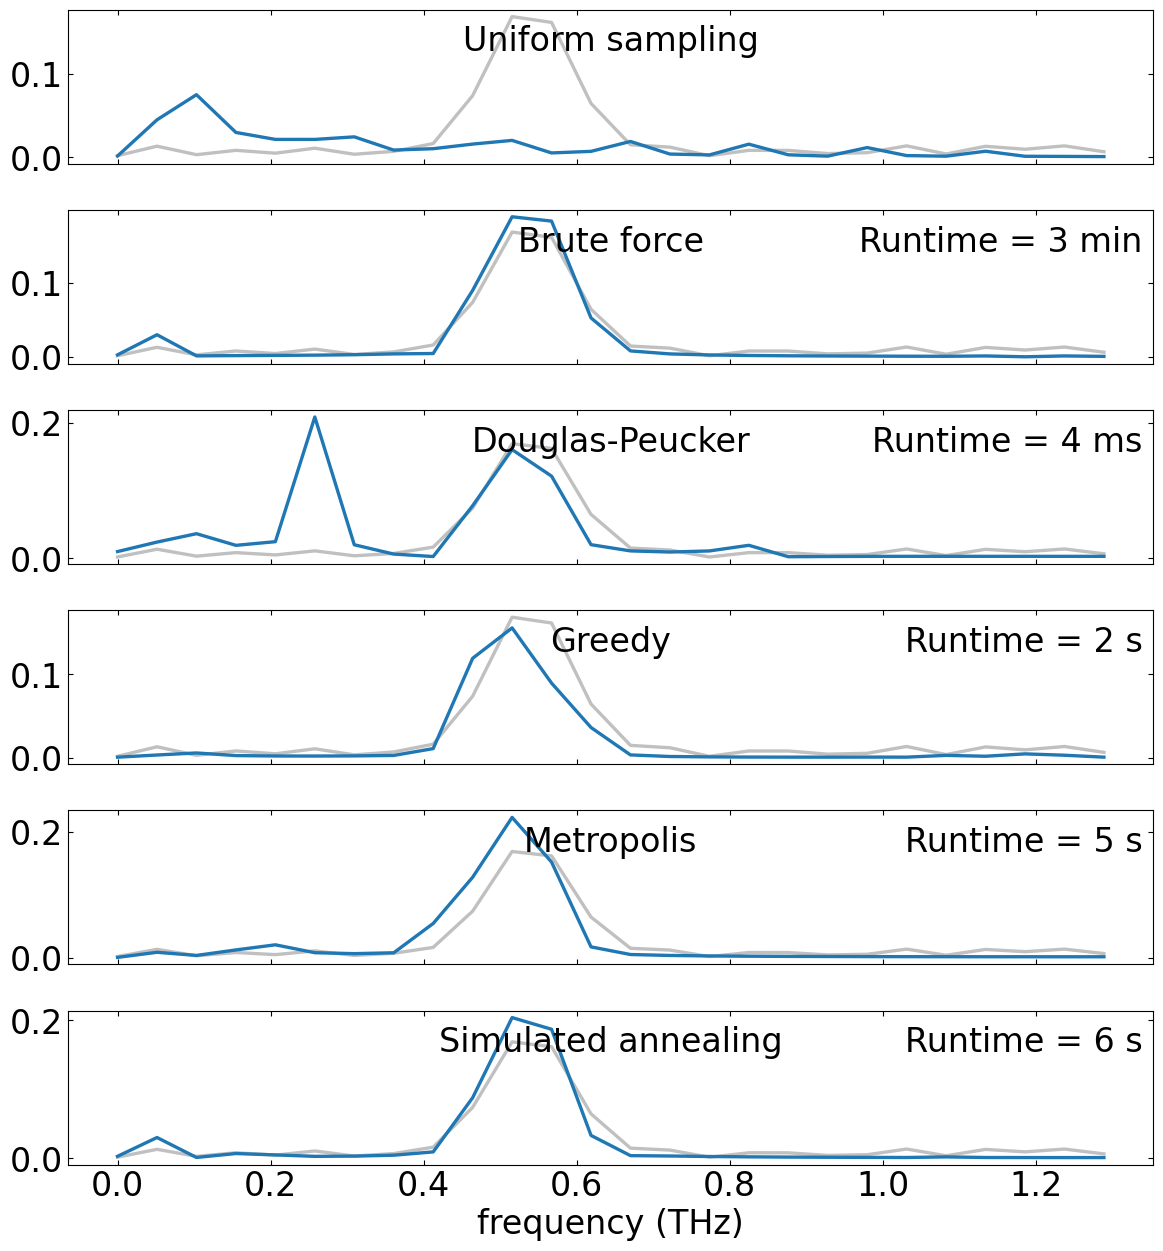

In [54]:
### POWER SPECTRUM

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

freqs = np.fft.rfftfreq(target_len, pixel_pitch*1e-3)
freqs /= 2*np.sin(np.deg2rad(theta/60))
freqs *= C
freqs *= 1e-12

for ax, method, sensors, runtime, score in zip(axs, optimised_samples.keys(), optimised_samples.values(), runtimes.values(), scores.values()):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(freqs, np.abs(np.fft.rfft(target, norm= "forward")), color= "silver")
    ax.plot(freqs, np.abs(np.fft.rfft(result, norm= "forward")))
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    ax.annotate(format_runtime(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

fig.savefig("./graphs/optimisation_comparason5c")
plt.show()